In [5]:
import sys
sys.path.append('../src')

In [6]:
import pykoopman as pk
from pykoopman.common import Linear2Ddynamics
import scipy
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [7]:
# Create instance of the dynamical system
sys = Linear2Ddynamics()

# Collect training data
n_pts = 51
n_int = 1
xx, yy = np.meshgrid(np.linspace(-1, 1, n_pts), np.linspace(-1, 1, n_pts))
x = np.vstack((xx.flatten(), yy.flatten()))
n_traj = x.shape[1]

X, Y = sys.collect_data(x, n_int, n_traj)

[Text(0, 0.5, '$x_2$'), Text(0.5, 0, '$x_1$')]

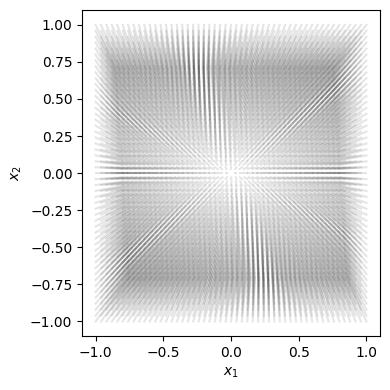

In [13]:
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(4, 4))
for traj_idx in range(n_traj):
    axs.plot([X[0, traj_idx::n_traj], Y[0, traj_idx::n_traj]],
             [X[1, traj_idx::n_traj], Y[1, traj_idx::n_traj]], '-k',alpha=0.1)
axs.set(ylabel=r'$x_2$',
        xlabel=r'$x_1$')

In [15]:
import lightning as L
class IncrementalSequenceLoss(L.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        max_look_forward = pl_module.look_forward
        if trainer.callback_metrics["loss"] < 1e-2 and \
                pl_module.masked_loss_metric.max_look_forward < max_look_forward:
            print("increase width size from {} to {}".format(
                pl_module.masked_loss_metric.max_look_forward,
                pl_module.masked_loss_metric.max_look_forward+1) )
            print("")
            pl_module.masked_loss_metric.max_look_forward += 1
            
look_forward = 1
dlk_regressor = pk.regression.NNDMD(look_forward=look_forward,
            config_encoder=dict(input_size=2, hidden_sizes=[32] * 2, output_size=2,
                                activations="linear"),
            config_decoder=dict(input_size=2, hidden_sizes=[32] * 2, output_size=2,
                                activations="linear"),
                                    batch_size=512, lbfgs=True, \
                                    normalize=True, normalize_mode='max',
                                    trainer_kwargs=dict(max_epochs=3, callbacks=[
        IncrementalSequenceLoss()]))

model = pk.Koopman(regressor=dlk_regressor)
model.fit(X.T, Y.T)

INFO: GPU available: True (cuda), used: True
[rank_zero.py:63 -                _info() ] GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
[rank_zero.py:63 -                _info() ] TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
[rank_zero.py:63 -                _info() ] IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
[rank_zero.py:63 -                _info() ] HPU available: False, using: 0 HPUs
/home/raj/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of

Epoch 2: 100%|█| 6/6 [00:00<00:00, 15.77it/s, v_num=7, loss=1.16e-10, rec_loss=2

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
[rank_zero.py:63 -                _info() ] `Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|█| 6/6 [00:00<00:00, 15.22it/s, v_num=7, loss=1.16e-10, rec_loss=2


Koopman(observables=Identity(),
        regressor=NNDMD(batch_size=512,
                        config_decoder={'activations': 'linear',
                                        'hidden_sizes': [32, 32],
                                        'input_size': 2, 'output_size': 2},
                        config_encoder={'activations': 'linear',
                                        'hidden_sizes': [32, 32],
                                        'input_size': 2, 'output_size': 2},
                        lbfgs=True, normalize_mode='max',
                        trainer_kwargs={'callbacks': [<__main__.IncrementalSequenceLoss object at 0x7293c5574790>,
                                                      <lightning.pytorch.callbacks.model_checkpoint.ModelCheckpoint object at 0x7293c5410c10>,
                                                      <lightning.pytorch.callbacks.progress.tqdm_progress.TQDMProgressBar object at 0x7293c5413490>,
                                                      <lightning.pytorch.callbacks.model_summary.ModelSummary object at 0x7293c5412b60>],
                                        'max_epochs': 3}))

In [16]:
# Testing on unseen trajectory
plt.figure(figsize=(4,4))
for i in range(len(traj_list)):
    plt.plot(traj_list[i][:,0],traj_list[i][:,1],'-k',alpha=0.05)
plt.plot(Xtest[:,0],Xtest[:,1],'-r',lw=3,label='test')
plt.plot(Xkoop_nn[:,0],Xkoop_nn[:,1],'--b',lw=2.5,label='nndmd')

plt.xlabel(r"$x_1$",size=20)
plt.ylabel(r"$x_2$",size=20)
plt.title(f"number of training trajectories = {len(traj_list)}",size=15)
plt.legend(loc='best',fontsize=15)

x0 = np.array([2, -4])  #np.array([2, -4])
T = 20
t = np.arange(0, T, nonlinear_sys.dt)
Xtest = nonlinear_sys.simulate(x0[:, np.newaxis], len(t)-1).T
Xtest = np.vstack([x0[np.newaxis, :], Xtest])

Xkoop_nn = dlk_regressor.simulate(x0[np.newaxis, :], n_steps=len(t)-1)

NameError: name 'traj_list' is not defined

<Figure size 400x400 with 0 Axes>